In [3]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [4]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [5]:
train_one = pd.read_csv("data/train2.csv")
test_one = pd.read_csv("data/test2.csv")

In [6]:
X = train_one.drop(['등록차량수','단지코드'],axis=1)
y = train_one['등록차량수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)

cb = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train, y_train)
pred = cb.predict(X_test)

mae(pred,y_test) 

119.57314535543328

In [7]:
prediction = train_one[['단지코드','등록차량수']]
prediction.loc[y_test.index.values,'y_pred'] = pred
prediction = prediction.dropna()

In [8]:
prediction[prediction['단지코드']=='C2416']

,단지코드,등록차량수,y_pred


In [796]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율'],
      dtype='object')

In [833]:
tmp2 = train_one[['단지코드','0~19 인구수','20~39 인구수','40~69 인구수','70세이상 인구수','공가수_비율']]

In [834]:
tmp = train[['단지코드','총인구수','지역','남/여_20~39세','남/여_40~69세','남/여_70세이상','세대당_인구','subway_dist','공가수','지하철역','버스정류장','등록차량수','단지내주차면수','총세대수','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율']].drop_duplicates().reset_index(drop=True)

In [835]:
tmp = pd.merge(tmp,tmp2,how='inner',on='단지코드')

In [836]:
tmp['단지내주차면수/총세대수'] = tmp.apply(lambda x : x['단지내주차면수']/x['총세대수'], axis=1)
tmp['등록차량수/단지내주차면수'] = tmp.apply(lambda x : x['등록차량수']/x['단지내주차면수'], axis=1)
tmp['단지내주차면수-총세대수'] = tmp.apply(lambda x : abs(x['단지내주차면수']-x['총세대수']), axis=1)

In [837]:
tmp = pd.merge(tmp,prediction,how='inner',on='단지코드')
tmp['mae'] = tmp.apply(lambda x : x['y_pred']-x['등록차량수_x'],axis=1)

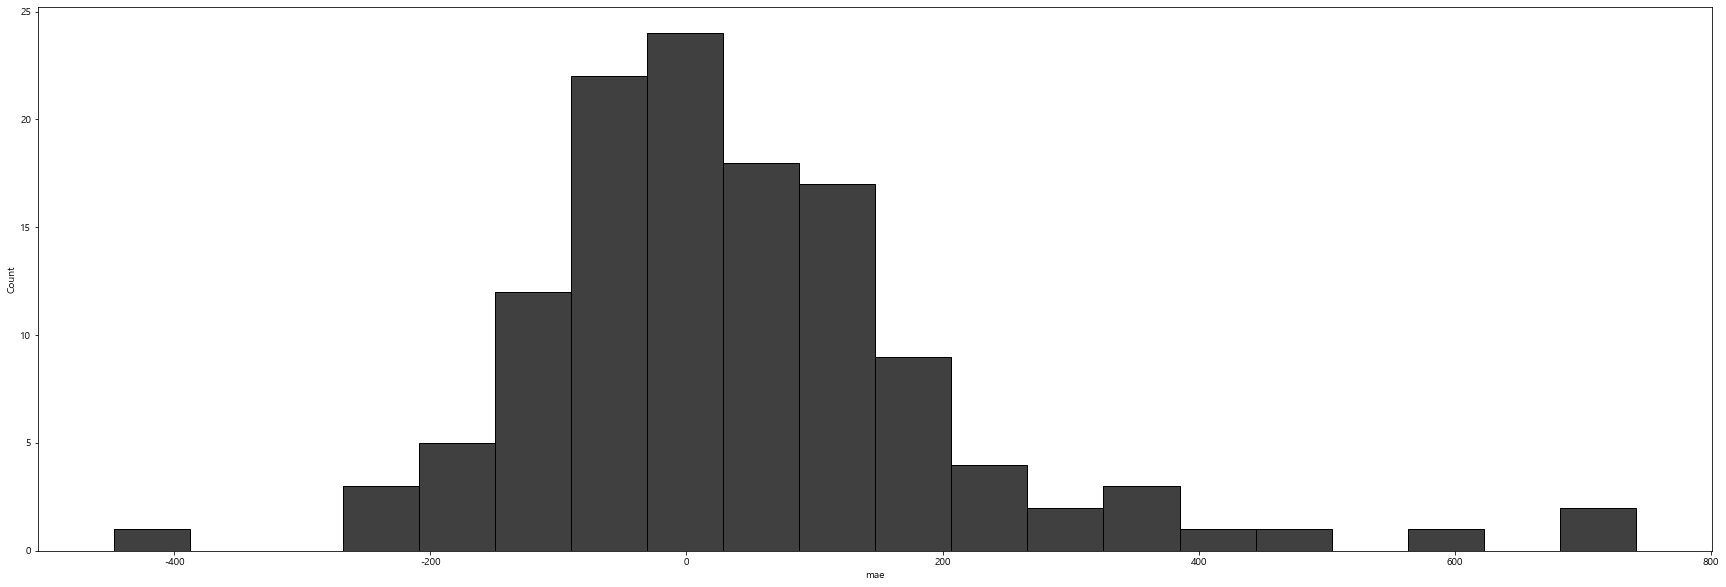

In [819]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='mae',color='black')

In [820]:
def score(x):
    if abs(x)<150:
        return 'good'
    elif abs(x)>150:
        return 'bad'

In [839]:
tmp['score'] = tmp.apply(lambda x : score(x['mae']),axis=1)
tmp['pred-총세대수'] = tmp.apply(lambda x : abs(x['y_pred']-x['총세대수']),axis=1)
tmp['pred-주차면수'] = tmp.apply(lambda x : abs(x['y_pred']-x['단지내주차면수']),axis=1)

In [840]:
good = tmp[(tmp['mae']<150)]
bad = tmp[(tmp['mae']>150)]

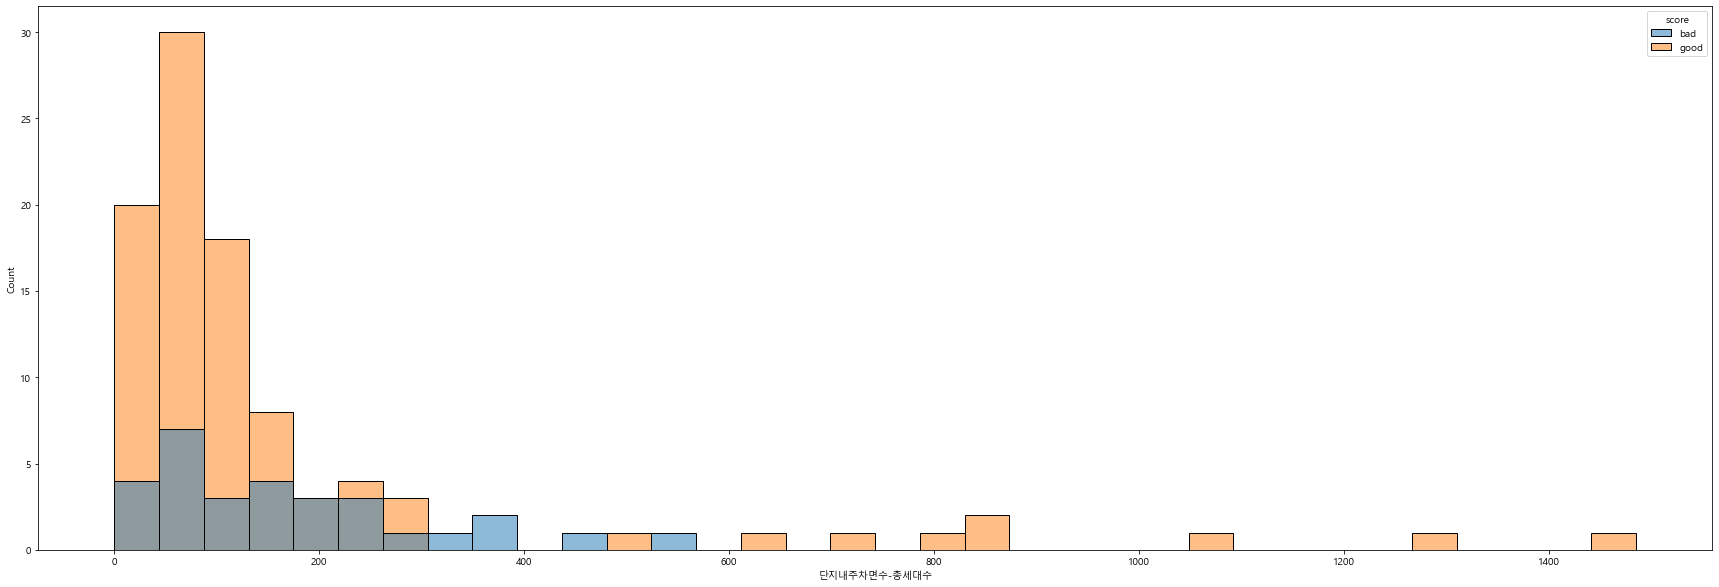

In [823]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='단지내주차면수-총세대수',hue='score')

In [841]:
tmp['score'].value_counts()

good    95
bad     30
Name: score, dtype: int64

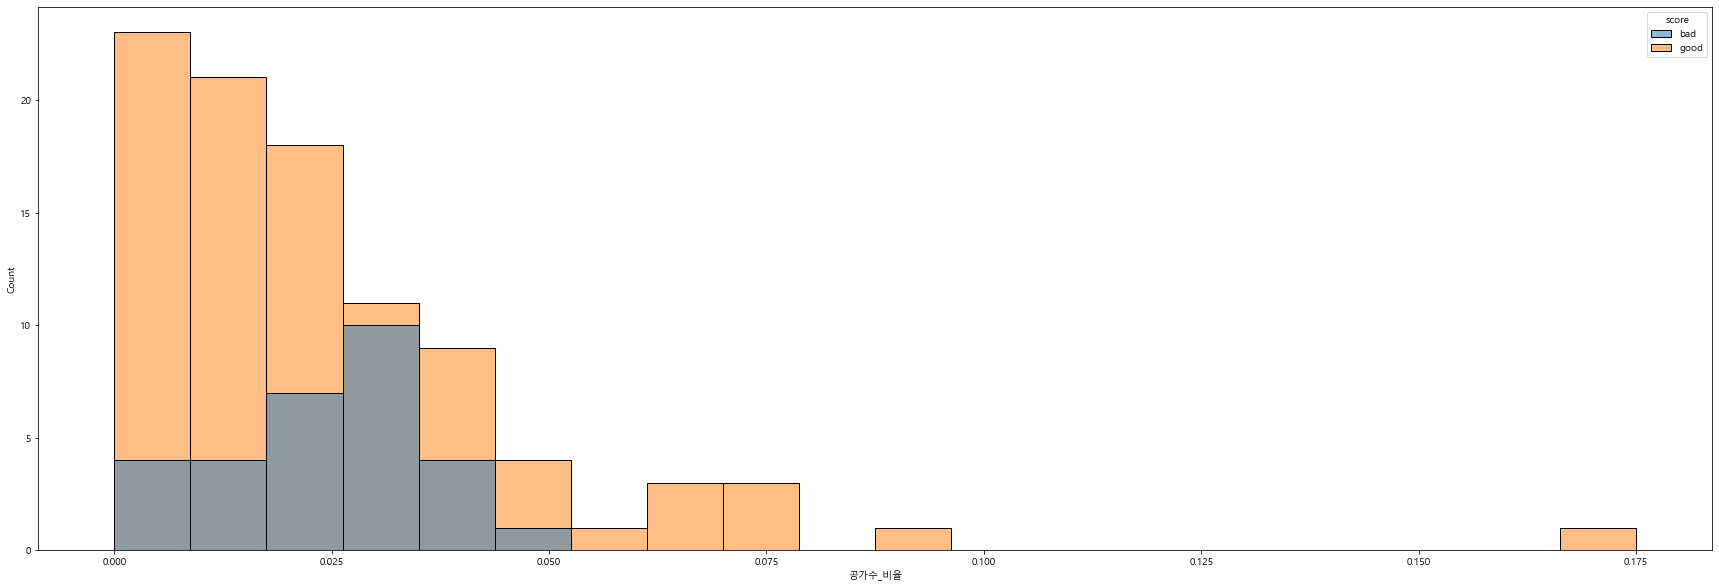

In [825]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='공가수_비율',hue='score')

In [826]:
print(good[good['공가수_비율']>0.024].shape[0])
print(good[good['공가수_비율']<0.024].shape[0])
print(bad[bad['공가수_비율']>0.024].shape[0])
print(bad[bad['공가수_비율']<0.024].shape[0])

39
64
15
7


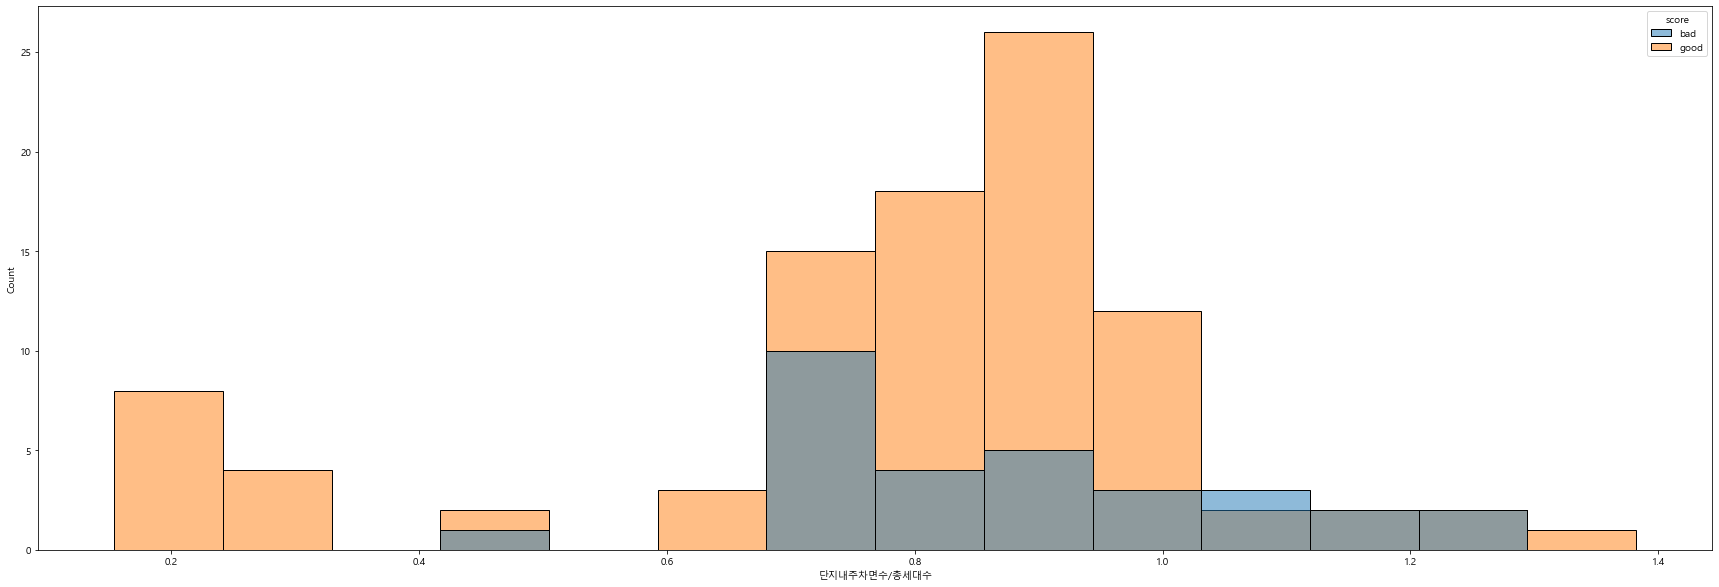

In [842]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='단지내주차면수/총세대수',hue='score')

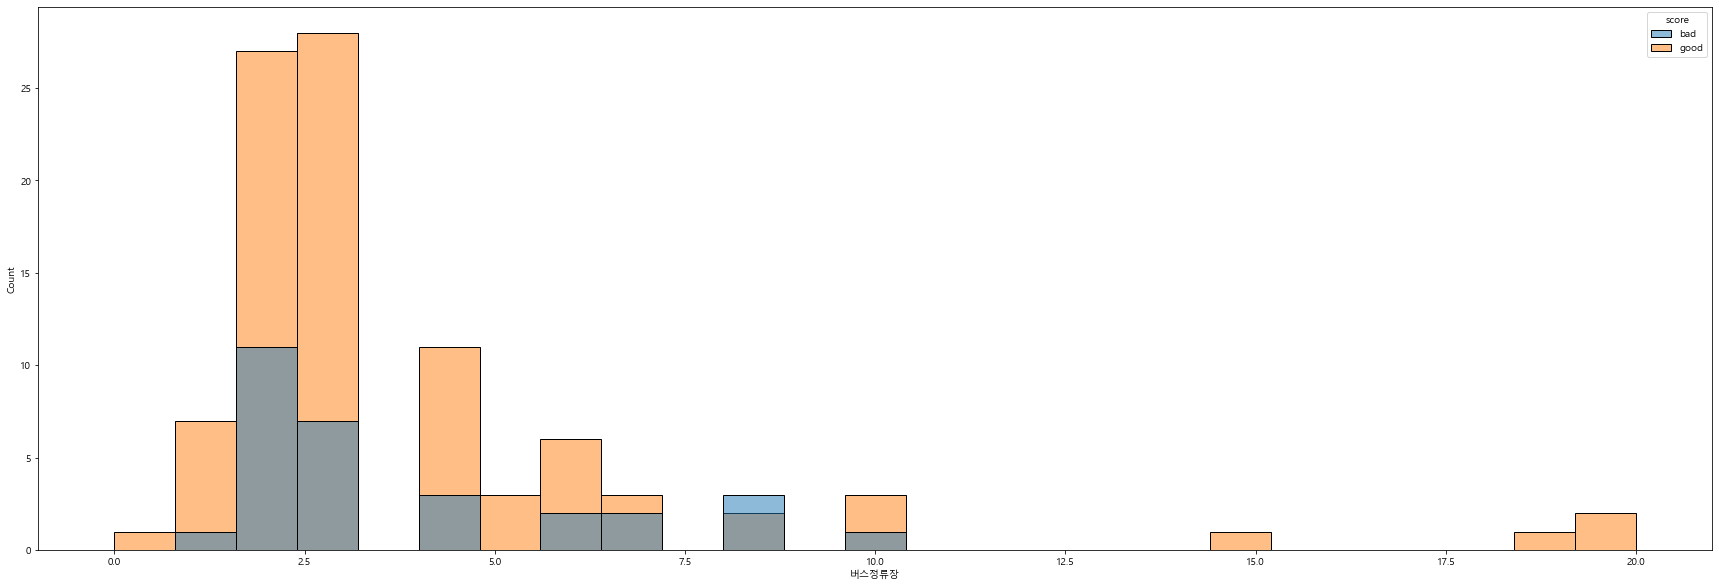

In [828]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='버스정류장',hue='score')

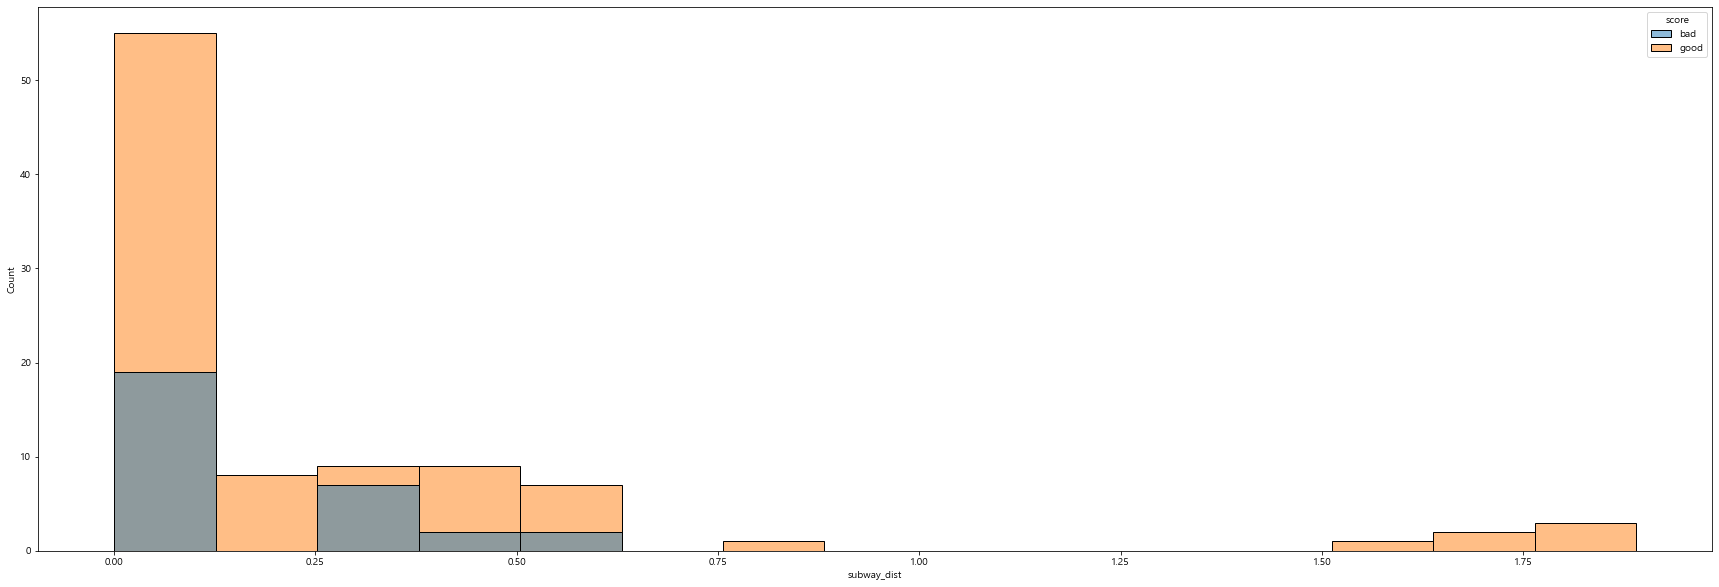

In [829]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='subway_dist',hue='score')

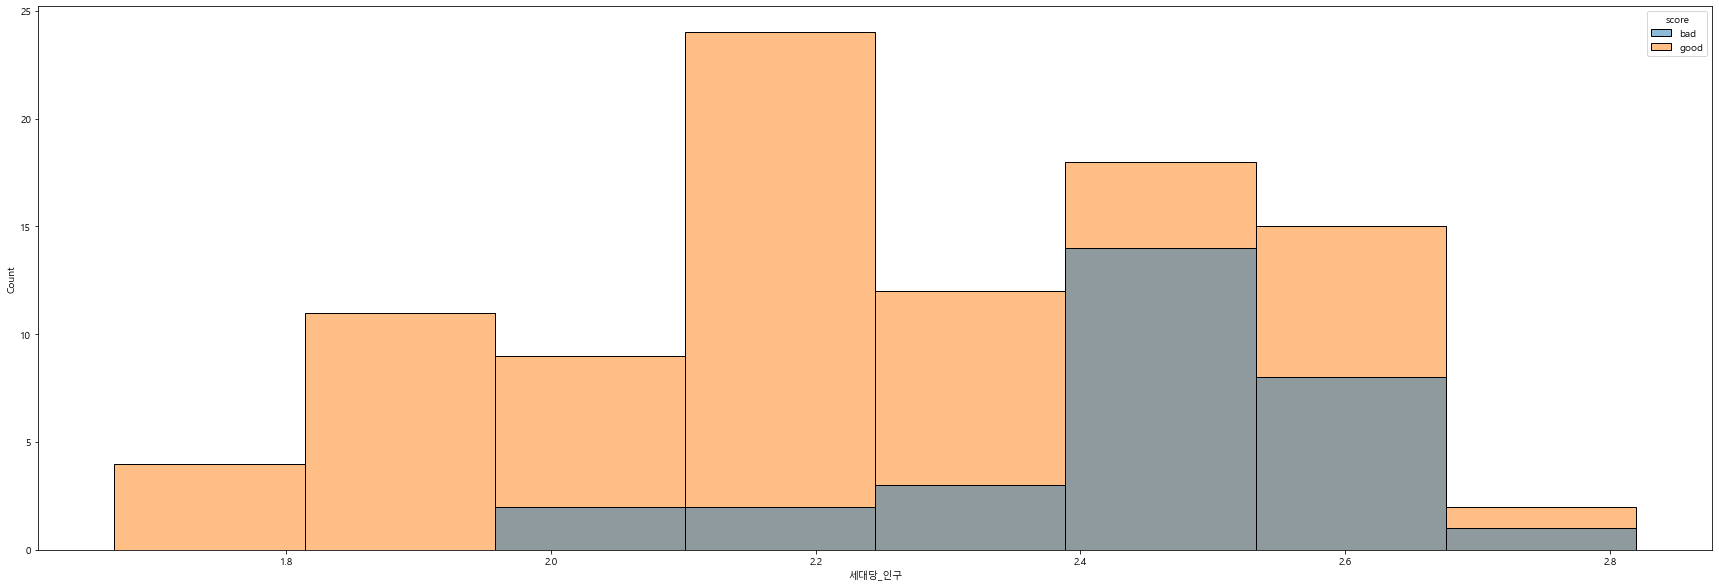

In [843]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='세대당_인구',hue='score')

In [852]:
tmp['cluster'] = tmp.apply(lambda x: 0 if x['세대당_인구']<2.4 else 1,axis=1)

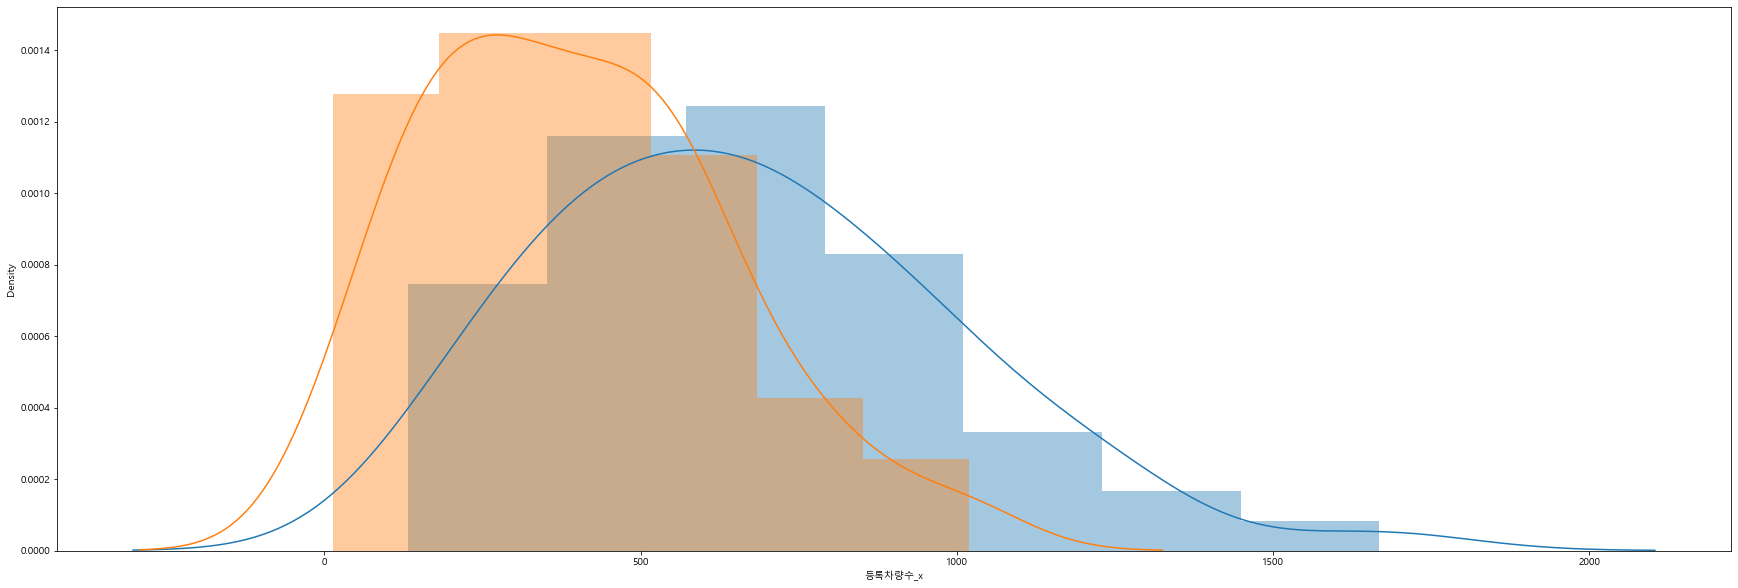

In [861]:
fig, ax = plt.subplots(figsize=(30,10))
sns.distplot(a=tmp.loc[tmp['cluster']==1,'등록차량수_x'])
sns.distplot(a=tmp.loc[tmp['cluster']==0,'등록차량수_x'])

In [844]:
tmp['법정동_세대수'] = tmp['총인구수']/tmp['세대당_인구']

In [845]:
tmp.columns

Index(['단지코드', '총인구수', '지역', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '세대당_인구',
       'subway_dist', '공가수', '지하철역', '버스정류장', '등록차량수_x', '단지내주차면수', '총세대수',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '0~19 인구수',
       '20~39 인구수', '40~69 인구수', '70세이상 인구수', '공가수_비율', '단지내주차면수/총세대수',
       '등록차량수/단지내주차면수', '단지내주차면수-총세대수', '등록차량수_y', 'y_pred', 'mae', 'score',
       'pred-총세대수', 'pred-주차면수', '법정동_세대수'],
      dtype='object')

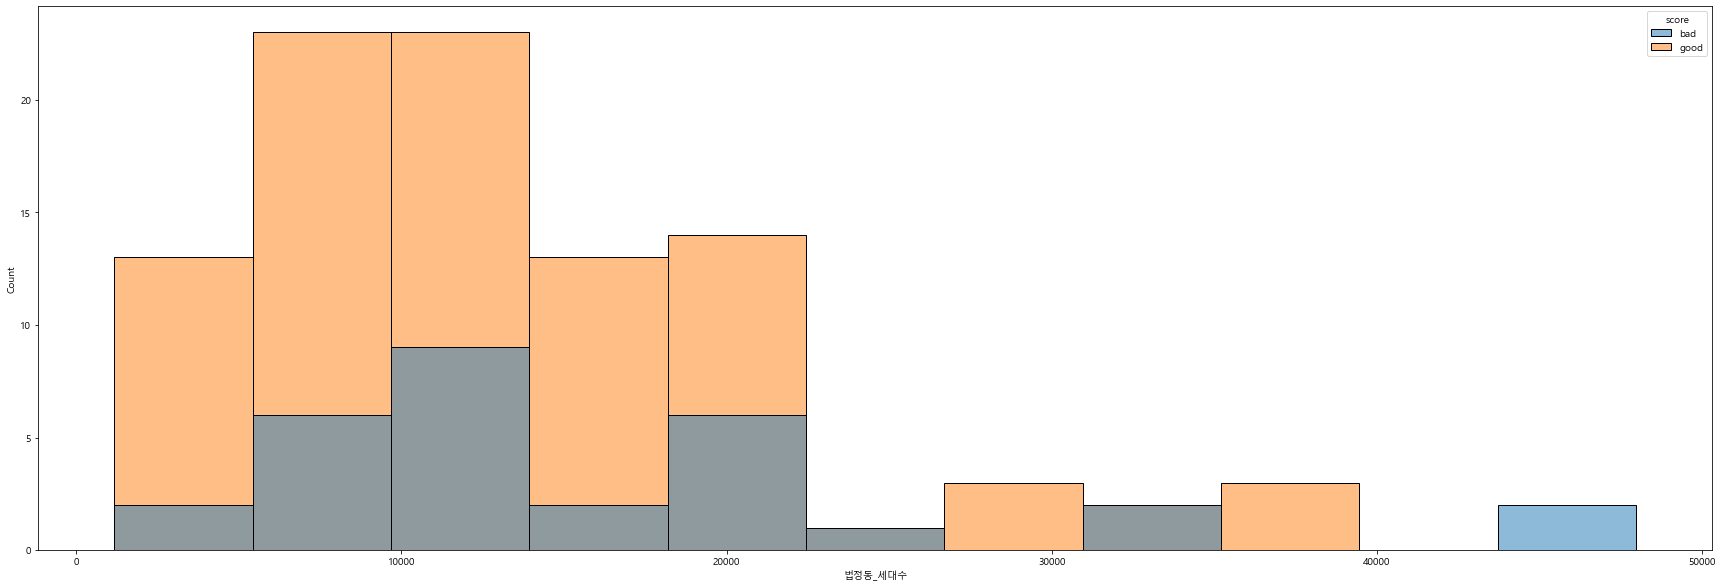

In [846]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='법정동_세대수',hue='score')

In [847]:
tmp['법정동-아파트세대수'] = tmp['총세대수']-tmp['법정동_세대수']

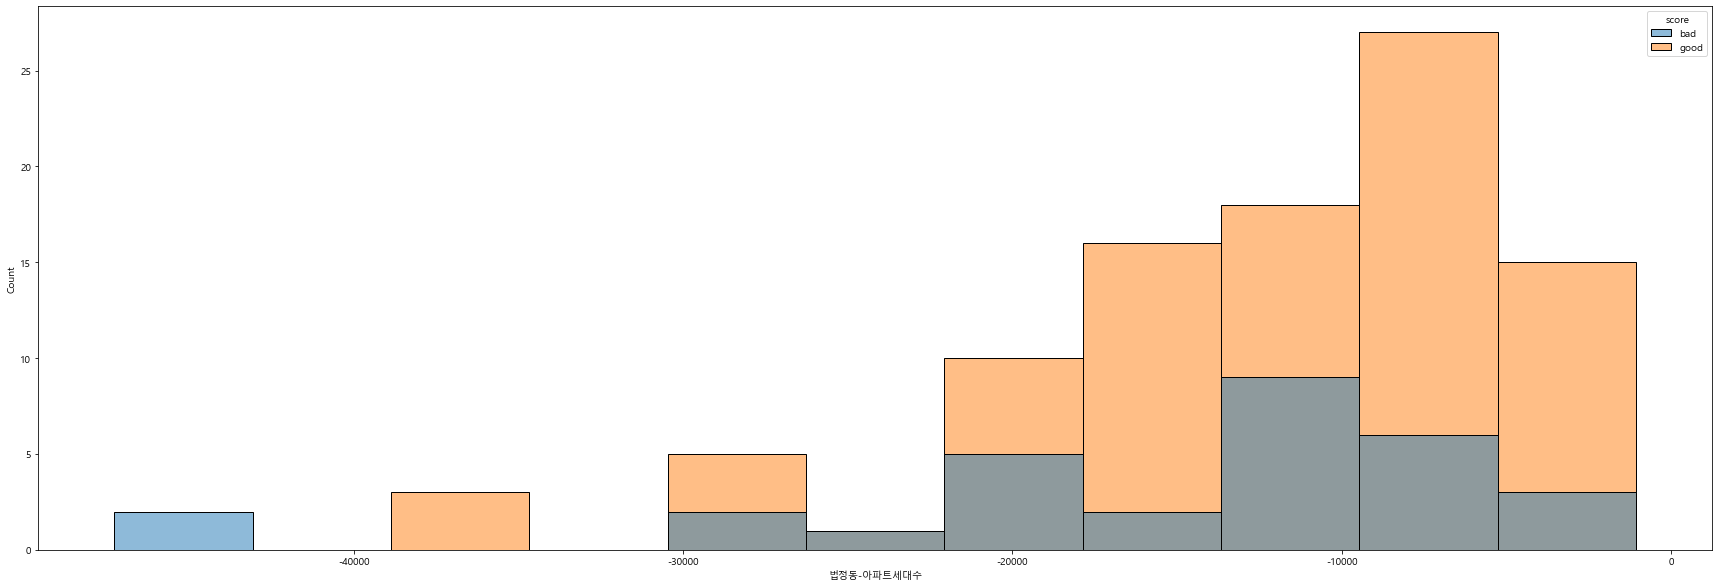

In [849]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=tmp,x='법정동-아파트세대수',hue='score')

In [788]:
print(good[good['세대당_인구']>2.4].shape[0])
print(good[good['세대당_인구']<=2.4].shape[0])
print(bad[bad['세대당_인구']>2.4].shape[0])
print(bad[bad['세대당_인구']<=2.4].shape[0])

120
294
53
15


In [724]:
train_one.shape

(414, 57)

In [753]:
print(train_one[train_one['세대당_인구']>2.4].shape[0])
print(train_one[train_one['세대당_인구']<2.4].shape[0])

165
243


In [869]:
train[train['세대당_인구']<2.4].corr()['등록차량수']

총세대수           0.0579
전용면적           0.0814
전용면적별세대수       0.2671
공가수            0.2781
임대보증금          0.2252
임대료           -0.0923
지하철역          -0.0859
버스정류장          0.1310
단지내주차면수        0.8168
등록차량수          1.0000
연면적            0.1463
위도            -0.0667
경도             0.0717
subway_dist   -0.1315
환승역 수          0.0363
총인구수           0.3310
세대당_인구         0.3448
남/여비율          0.1787
남/여_0~19세      0.3429
남/여_20~39세    -0.1180
남/여_40~69세     0.0186
남/여_70세이상      0.2943
0~19세_비율       0.3547
20~39세_비율      0.3219
40~69세_비율     -0.3001
70세이상_비율      -0.4133
Name: 등록차량수, dtype: float64

In [870]:
train[train['세대당_인구']>=2.4].corr()['등록차량수']

총세대수           0.7226
전용면적           0.2537
전용면적별세대수       0.2126
공가수           -0.0771
임대보증금          0.2812
임대료            0.0475
지하철역           0.0343
버스정류장          0.0427
단지내주차면수        0.8403
등록차량수          1.0000
연면적            0.3437
위도            -0.1089
경도             0.2019
subway_dist   -0.1648
환승역 수          0.0817
총인구수          -0.0278
세대당_인구         0.1063
남/여비율         -0.1691
남/여_0~19세      0.2706
남/여_20~39세    -0.4117
남/여_40~69세    -0.0482
남/여_70세이상      0.1368
0~19세_비율       0.1064
20~39세_비율      0.2474
40~69세_비율     -0.2120
70세이상_비율      -0.2037
Name: 등록차량수, dtype: float64

In [785]:
train_one[train_one['세대당_인구']==2.4].shape[0]

6

In [755]:
result = pd.read_csv("data/result.csv")

In [760]:
test_one['y_pred'] = result['y2']

In [771]:
test.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '지하철역', '버스정류장', '단지내주차면수', '단지명', '도로명주소', '임대보증금', '임대료',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율'],
      dtype='object')

In [773]:
tmp = test[['단지코드','총세대수','단지내주차면수']].drop_duplicates().reset_index(drop=True)

In [775]:
tmp = pd.merge(test_one,tmp,how='left',on='단지코드')

In [783]:
tmp[tmp['세대당_인구']>2.4][['총인구수','세대당_가능주차면수','y_pred','총세대수','단지내주차면수','세대당_인구']]

,총인구수,세대당_가능주차면수,y_pred,총세대수,단지내주차면수,세대당_인구
0,"41,315.0000",0.9058,761.4265,754,683,2.5800
1,"41,315.0000",0.8981,"1,093.0518",1354,1216,2.5800
4,"19,109.5000",0.8574,"1,166.7916",1297,1112,2.8600
5,"21,629.6667",0.8592,"1,666.8050",1974,1696,2.8933
6,"55,531.0000",0.8139,950.0398,1349,1098,2.6400
15,"22,475.5000",0.5000,227.7336,420,210,2.4650
22,"37,059.0000",0.8602,531.8849,558,480,2.5800
23,"37,059.0000",0.8589,432.5508,638,548,2.5800
24,"36,060.0000",0.9049,424.7632,494,447,2.6600
30,"81,775.0000",0.8463,947.4836,1301,1101,2.6000


In [782]:
bad[['총세대수','단지내주차면수','y_pred','등록차량수_x']].drop_duplicates()

,총세대수,단지내주차면수,y_pred,등록차량수_x
0,545,624.0000,484.7387,205.0000
17,405,296.0000,429.5817,73.0000
37,970,420.0000,560.6658,386.0000
150,753,682.0000,745.6142,496.0000
154,1144,950.0000,"1,071.6505",376.0000
222,708,638.0000,649.5608,465.0000
227,1002,775.0000,771.7660,554.0000
253,1124,"1,129.0000",891.0402,657.0000
270,514,362.0000,399.1828,246.0000
328,700,592.0000,581.7640,403.0000
